<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/Stock_NeurIPS2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



# Content

* [1. Task Description](#0)
* [2. Install Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. A List of Python Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download and Preprocess Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5. Build Market Environment in OpenAI Gym-style](#4)  
    * [5.1. Data Split](#4.1)  
    * [5.3. Environment for Training](#4.2)    
* [6. Train DRL Agents](#5)
* [7. Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
  

<a id='0'></a>
# Part 1. Task Discription

We train a DRL agent for stock trading. This task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.

We specify the state-action-reward as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes many features and learns by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 consituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.


The data for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Install Python Packages

<a id='1.1'></a>
## 2.1. Install packages


In [ ]:
## install finrl library
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git


<a id='1.2'></a>
## 2.2. A list of Python packages 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools



/Users/piers/.local/share/virtualenvs/explore_deeprl-G_e47ABP/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/piers/.local/share/virtualenvs/explore_deeprl-G_e47ABP/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
import warnings
warnings.filterwarnings("ignore")

<a id='1.4'></a>
## 2.4. Create Folders

In [3]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



In [4]:
#print(dir(config_tickers))
#print(config_tickers.SINGLE_TICKER)

In [5]:
TRAIN_START_DATE, TEST_START_DATE, TRADE_START_DATE

('2014-01-06', '2020-08-01', '2021-11-01')

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).



-----
class YahooDownloader:
    Retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()


In [6]:
# from config.py, TRAIN_START_DATE is a string
TRAIN_START_DATE
# from config.py, TRAIN_END_DATE is a string
TRAIN_END_DATE

'2020-07-31'

In [7]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2020-07-01'
TRADE_START_DATE = '2020-07-01'
TRADE_END_DATE = '2021-10-31'


In [15]:
# S&P 500: ^GSPC or SPY
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
config_tickers.SINGLE_TICKER=['MCD']
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = config_tickers.SINGLE_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3230, 8)


In [16]:
#print(config_tickers.DOW_30_TICKER)

In [17]:
df.shape

(3230, 8)

In [18]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,62.380001,64.129997,62.200001,42.632057,8652700,MCD,4
1,2009-01-05,63.259998,63.840000,62.889999,42.504997,7692900,MCD,0
2,2009-01-06,63.990002,64.459999,61.830002,41.555389,10855700,MCD,1
3,2009-01-07,61.930000,62.570000,60.840000,40.953526,7910400,MCD,2
4,2009-01-08,60.830002,60.830002,59.700001,40.472027,9382300,MCD,3


# Part 4: Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

In [19]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3229, 8)
Successfully added vix
Successfully added turbulence index


In [20]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)


In [21]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,MCD,62.380001,64.129997,62.200001,42.632057,8652700.0,4.0,0.000000,42.748217,42.388837,0.000000,66.666667,100.000000,42.632057,42.632057,39.189999,0.0
1,2009-01-05,MCD,63.259998,63.840000,62.889999,42.504997,7692900.0,0.0,-0.002851,42.748217,42.388837,0.000000,66.666667,100.000000,42.568527,42.568527,39.080002,0.0
2,2009-01-06,MCD,63.990002,64.459999,61.830002,41.555389,10855700.0,1.0,-0.033080,43.407565,41.054064,0.000000,-100.000000,100.000000,42.230815,42.230815,38.560001,0.0
3,2009-01-07,MCD,61.930000,62.570000,60.840000,40.953526,7910400.0,2.0,-0.067748,43.509813,40.313172,0.000000,-133.333333,100.000000,41.911492,41.911492,43.389999,0.0
4,2009-01-08,MCD,60.830002,60.830002,59.700001,40.472027,9382300.0,3.0,-0.104320,43.514001,39.733197,0.000000,-122.252272,100.000000,41.623599,41.623599,42.560001,0.0
5,2009-01-09,MCD,60.709999,60.950001,59.849998,40.171097,7150700.0,4.0,-0.137211,43.446801,39.316230,0.000000,-89.829825,91.782636,41.381516,41.381516,42.820000,0.0
6,2009-01-12,MCD,60.099998,61.230000,59.750000,40.231274,8682900.0,0.0,-0.153215,43.293378,39.141012,2.638058,-71.870808,73.955440,41.217195,41.217195,45.840000,0.0
7,2009-01-13,MCD,60.310001,60.799999,58.820000,39.669556,9082600.0,1.0,-0.188198,43.235604,38.811877,2.102474,-92.041301,80.418189,41.023740,41.023740,43.270000,0.0
8,2009-01-14,MCD,58.509998,58.619999,56.410000,38.338745,15340200.0,2.0,-0.275586,43.461259,37.989556,1.403913,-152.846769,88.395149,40.725407,40.725407,49.139999,0.0
9,2009-01-15,MCD,57.200001,58.590000,56.549999,38.773430,12166300.0,3.0,-0.311177,43.389811,37.670609,11.355798,-120.894812,88.395149,40.530210,40.530210,51.000000,0.0


<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period: 2009-01-01 to 2020-07-01

Trading data period: 2020-07-01 to 2021-10-31


In [22]:
TRAIN_START_DATE, TRAIN_END_DATE, TRADE_START_DATE, TRADE_END_DATE

('2009-01-01', '2020-07-01', '2020-07-01', '2021-10-31')

In [23]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

2893
336


In [24]:
train.tail()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
2888,2020-06-24,MCD,184.960007,185.710007,181.339996,174.158173,4146600.0,2.0,0.715475,189.350962,170.906736,49.206463,-44.927598,8.471895,176.649213,172.284480,33.840000,0.247741
2889,2020-06-25,MCD,183.509995,184.080002,180.330002,172.712326,3145200.0,3.0,0.233978,189.630961,170.180684,48.326506,-72.462581,10.883005,176.998388,172.575943,32.220001,0.107812
2890,2020-06-26,MCD,182.369995,182.809998,178.880005,169.858353,5107400.0,4.0,-0.373597,190.193842,168.995979,46.623957,-109.484537,14.345772,177.171382,172.932178,34.730000,0.427658
2891,2020-06-29,MCD,180.570007,182.830002,179.169998,172.750107,2622200.0,0.0,-0.614678,190.363326,168.390836,48.524803,-103.425708,14.280285,177.490836,173.284509,31.780001,0.462314
2892,2020-06-30,MCD,182.919998,185.199997,181.889999,174.328308,3163100.0,1.0,-0.670658,190.411953,168.047365,49.539362,-71.554578,6.551999,177.674518,173.681448,30.430000,0.133518


In [25]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2020-07-01,MCD,184.949997,186.440002,183.720001,174.507858,2193800.0,2.0,-0.692551,190.071555,167.572211,49.656143,-58.579242,2.668794,177.872322,173.819935,28.620001,0.001759
1,2020-07-02,MCD,187.000000,187.000000,182.860001,173.430511,2690200.0,3.0,-0.787754,189.709649,167.015554,48.952923,-68.599755,5.229391,177.892462,173.963152,27.680000,0.058148
2,2020-07-06,MCD,186.000000,188.720001,184.139999,178.136749,3171500.0,0.0,-0.477939,188.664551,167.242265,52.023291,-25.078841,0.374055,178.038809,174.155079,27.940001,1.172653
3,2020-07-07,MCD,187.369995,187.850006,185.250000,175.604080,2399600.0,1.0,-0.431797,185.792044,168.524298,50.337743,-41.207933,0.374055,178.121699,174.207633,29.430000,0.314803
4,2020-07-08,MCD,185.500000,187.229996,184.750000,175.632462,2776400.0,2.0,-0.388460,183.291046,169.733453,50.356389,-47.737054,1.370535,178.192080,174.316673,28.080000,0.000116


In [26]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [27]:
stock_dimension = len(train.tic.unique())
#2stock dimension: price plus holding for each stock
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 1, State Space: 11


In [40]:
#make costs larger
base_cost = 0.005

buy_cost_list = sell_cost_list = [base_cost] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)
#Instantiate the trading environment
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = None, **env_kwargs)

In [41]:
import optuna
from optuna.integration import PyTorchLightningPruningCallback
import joblib
from pprint import pprint

from typing import Any
from typing import Dict

from IPython.display import clear_output


In [42]:
#Instantiate the training environment
# Also instantiate our training gent
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))
agent = DRLAgent(env = env_train)

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [49]:
def sample_a2c_params(trial: optuna.Trial) -> Dict[str, Any]:
    """Sampler for A2C hyperparameters."""
    gamma = 1.0 - trial.suggest_float("gamma", 0.0001, 0.1, log=True)
    max_grad_norm = trial.suggest_float("max_grad_norm", 0.3, 5.0, log=True)
    gae_lambda = 1.0 - trial.suggest_float("gae_lambda", 0.001, 0.2, log=True)
    n_steps = 2 ** trial.suggest_int("exponent_n_steps", 3, 10)
    learning_rate = trial.suggest_float("lr", 1e-5, 1, log=True)
    ent_coef = trial.suggest_float("ent_coef", 0.00000001, 0.1, log=True)
    #ortho_init = trial.suggest_categorical("ortho_init", [False, True])
    #net_arch = trial.suggest_categorical("net_arch", ["tiny", "small"])
    #activation_fn = trial.suggest_categorical("activation_fn", ["tanh", "relu"])

    # Display true values
    trial.set_user_attr("gamma_", gamma)
    trial.set_user_attr("gae_lambda_", gae_lambda)
    trial.set_user_attr("n_steps", n_steps)
    trial.set_user_attr("learning_rate", learning_rate)
    trial.set_user_attr("ent_coef", ent_coef)
    trial.set_user_attr("max_grad_norm", max_grad_norm)

    #net_arch = [
    #    {"pi": [64], "vf": [64]} if net_arch == "tiny" else {"pi": [64, 64], "vf": [64, 64]}
    #]

    #activation_fn = {"tanh": nn.Tanh, "relu": nn.ReLU}[activation_fn]

    return {
        "n_steps": n_steps,
        "gamma": gamma,
        "gae_lambda": gae_lambda,
        "learning_rate": learning_rate,
        "ent_coef": ent_coef,
        "max_grad_norm": max_grad_norm,
        #"policy_kwargs": {
        #    "net_arch": net_arch,
        #    "activation_fn": activation_fn,
        #    "ortho_init": ortho_init,
        #},
    }


In [50]:
#Calculate the Sharpe ratio
#This is our objective for tuning
def calculate_sharpe(df):
    df['daily_return'] = df['account_value'].pct_change(1)
    if df['daily_return'].std() !=0:
        sharpe = (252**0.5)*df['daily_return'].mean()/ \
              df['daily_return'].std()
        return sharpe
    else:
        return 0

## Callbacks
1. The callback will terminate if the improvement margin is below certain point
2. It will terminate after certain number of trial_number are reached, not before that
3. It will hold its patience to reach the threshold

In [53]:
class LoggingCallback:
    def __init__(self,threshold,trial_number,patience):
        '''
        threshold:int tolerance for increase in sharpe ratio
        trial_number: int Prune after minimum number of trials
        patience: int patience for the threshold
        '''
        self.threshold = threshold
        self.trial_number  = trial_number
        self.patience = patience
        self.cb_list = [] #Trials list for which threshold is reached
    def __call__(self,study:optuna.study, frozen_trial:optuna.Trial):
        #Setting the best value in the current trial
        study.set_user_attr("previous_best_value", study.best_value)

        #Checking if the minimum number of trials have pass
        if frozen_trial.number >self.trial_number:
            previous_best_value = study.user_attrs.get("previous_best_value",None)
            #Checking if the previous and current objective values have the same sign
            if previous_best_value * study.best_value >=0:
                #Checking for the threshold condition
                if abs(previous_best_value-study.best_value) < self.threshold: 
                    self.cb_list.append(frozen_trial.number)
                    #If threshold is achieved for the patience amount of time
                    if len(self.cb_list)>self.patience:
                        print('The study stops now...')
                        print('With number',frozen_trial.number ,'and value ',frozen_trial.value)
                        print('The previous and current best values are {} and {} respectively'
                              .format(previous_best_value, study.best_value))
                        study.stop()
                        

In [54]:
def objective(trial:optuna.Trial):
    #Trial will suggest a set of hyperparamters from the specified range
    hyperparameters = sample_a2c_params(trial)
    model_a2c = agent.get_model("a2c", model_kwargs = hyperparameters)
    #You can increase it for better comparison
    trained_a2c = agent.train_model(model=model_a2c,
                                    tb_log_name="a2c",
                                    total_timesteps=50000)
    trained_a2c.save('models/a2c_{}.pth'.format(trial.number))
    clear_output(wait=True)
    
    #For the given hyperparamters, determine the account value in the trading period
    df_account_value, df_actions = DRLAgent.DRL_prediction(
                                        model=trained_a2c, 
                                        environment = e_train_gym
                                        #environment = e_trade_gym
                                    )
    #Calculate sharpe from the account value
    sharpe = calculate_sharpe(df_account_value)
    print(trial.number," Sharpe=:",sharpe)

    return sharpe


In [55]:
#Create a study object and specify the direction as 'maximize'
#As you want to maximize sharpe
#Pruner stops not promising iterations
#Use a pruner, else you will get error related to divergence of model
#You can also use Multivariate samplere
#sampler = optuna.samplers.TPESampler(multivarite=True,seed=42)

sampler = optuna.samplers.TPESampler(seed=1234)
study = optuna.create_study(study_name="a2c_study",direction='maximize',
                            sampler = sampler, pruner=optuna.pruners.HyperbandPruner())

logging_callback = LoggingCallback(threshold=1e-5,patience=30,trial_number=5)
#You can increase the n_trials for a better search space scanning
study.optimize(objective, n_trials=30,catch=(ValueError,),callbacks=[logging_callback])

[I 2022-12-21 18:39:31,545] Trial 29 finished with value: 0.7900924659384965 and parameters: {'gamma': 0.06699932454106995, 'max_grad_norm': 1.4559957341794554, 'gae_lambda': 0.01872825479429275, 'exponent_n_steps': 5, 'lr': 0.005081415928101521, 'ent_coef': 5.237937215569122e-07}. Best is trial 26 with value: 0.7901374848443632.


hit end!
29  Sharpe=: 0.7900924659384965


In [136]:
len(tics)
tics[0]

'MCD'

### Advanced

In [178]:
#Main method
# Calculates Trade Performance for Objective
# Called from objective method
# Returns selected trade perf metric(s)
# Requires actions and associated prices

def calc_trade_perf_metric(df_actions, 
                           df_prices_trade,
                           tp_metric,
                           dbg=False):
  
    #print(df_prices_trade.head)
    
    df_actions_p, df_prices_p, tics = prep_data(df_actions.copy(),
                                                df_prices_trade.copy())
    
    #fix action column name if only one ticker
    if len(tics)==1:
        df_actions_p.rename(columns={'actions': tics[0]}, inplace=True)
    
    # actions predicted by trained model on trade data
    df_actions_p.to_csv('df_actions.csv') 

    
    # Confirms that actions, prices and tics are consistent
    df_actions_s, df_prices_s, tics_prtfl = \
        sync_tickers(df_actions_p.copy(),df_prices_p.copy(),tics)
    
    # copy to ensure that tics from portfolio remains unchanged
    tics = tics_prtfl.copy()
    
    # Analysis is performed on each portfolio ticker
    perf_data= collect_performance_data(df_actions_s, df_prices_s, tics)
    # profit/loss for each ticker
    pnl_all = calc_pnl_all(perf_data, tics)
    # values for trade performance metrics
    perf_results = calc_trade_perf(pnl_all)
    df = pd.DataFrame.from_dict(perf_results, orient='index')
    
    # calculate and return trade metric value as objective
    m = calc_trade_metric(df,tp_metric)
    print(f'Ratio Avg Win/Avg Loss: {m}')
    #k = str(len(tpm_hist)+1)
    ## save metric value
    # tpm_hist[k] = m
    
    return m

In [181]:
# Supporting methods
def calc_trade_metric(df,metric='avgwl'):
    '''# trades', '# wins', '# losses', 'wins total value', 'wins avg value',
       'losses total value', 'losses avg value'''
    # For this tutorial, the only metric available is the ratio of 
    #  average values of winning to losing trades. Others are in development.
    
    # some test cases produce no losing trades.
    # The code below assigns a value as a multiple of the highest value during
    # previous hp optimization runs. If the first run experiences no losses,
    # a fixed value is assigned for the ratio
    tpm_mult = 1.0
    avgwl_no_losses = 25
    if metric == 'avgwl':
        if sum(df['# losses']) == 0:
            try:
                return avgwl_no_losses #max(tpm_hist.values())*tpm_mult
            except ValueError:
                return avgwl_no_losses
        avg_w = sum(df['wins total value'])/sum(df['# wins'])
        avg_l = sum(df['losses total value'])/sum(df['# losses'])
        m = abs(avg_w/avg_l)

    return m


def prep_data(df_actions,
              df_prices_trade):
    
    df=df_prices_trade[['date','close','tic']]
    df['Date'] = pd.to_datetime(df['date'])
    #df = df.set_index('Date', append=True)
    df = df.set_index('Date')
    df['date'] = df.index
    # set indices on both df to datetime
    #idx = pd.to_datetime(df_actions.index, infer_datetime_format=True)
    #df_actions.index=idx
    df_actions['Date'] = pd.to_datetime(df_actions['date'])
    #df_actions = df_actions.set_index('Date', append=True)
    df_actions = df_actions.set_index('Date')
    df_actions['date'] = df_actions.index
    tics = np.unique(df.tic)
    n_tics = len(tics)
    print(f'Number of tickers: {n_tics}')
    print(f'Tickers: {tics}')
    dategr = df.groupby('tic')
    p_d={t:dategr.get_group(t).loc[:,'close'] for t in tics}
    df_prices = pd.DataFrame.from_dict(p_d)
    df_prices.index = df_prices.index.normalize()
    df_prices['date'] = df_prices.index
    
    return df_actions, df_prices, tics


# prepares for integrating action and price files
def link_prices_actions(df_a,
                        df_p):
    cols_a = [t + '_a' for t in df_a.columns]
    df_a.columns = cols_a
    cols_p = [t + '_p' for t in df_p.columns]
    df_p.columns = cols_p
    return df_a, df_p


def sync_tickers(df_actions,df_tickers_p,tickers):
    # Some DOW30 components may not be included in portfolio
    # passed tickers includes all DOW30 components
    # actions and ticker files may have different length indices
    if len(df_actions) != len(df_tickers_p):
        msng_dates = set(df_actions.index)^set(df_tickers_p.index)
        try:
            #assumption is prices has one additional timestamp (row)
            df_tickers_p.drop(msng_dates,inplace=True)
        except:
            df_actions.drop(msng_dates,inplace=True)
    df_actions, df_tickers_p = link_prices_actions(df_actions,df_tickers_p)
    # identify any DOW components not in portfolio
    t_not_in_a = [t for t in tickers if t + '_a' not in list(df_actions.columns)]
  
    # remove t_not_in_a from df_tickers_p
    drop_cols = [t + '_p' for t in t_not_in_a]
    df_tickers_p.drop(columns=drop_cols,inplace=True)
    
    # Tickers in portfolio
    tickers_prtfl = [c.split('_')[0] for c in df_actions.columns]
    remove_item = 'date'
    if remove_item in tickers_prtfl: tickers_prtfl.remove(remove_item)
    
    return df_actions,df_tickers_p, tickers_prtfl

def collect_performance_data(dfa,dfp,tics, dbg=False):
    
    perf_data = {}
    # In current version, files columns include secondary identifier
    for t in tics:
        # actions: purchase/sale of DOW equities
        acts = dfa['_'.join([t,'a'])].values
        # ticker prices
        prices = dfp['_'.join([t,'p'])].values
        # market value of purchases/sales
        tvals_init = np.multiply(acts,prices)
        d={'actions':acts, 'prices':prices,'init_values':tvals_init}
        perf_data[t]=d

    return perf_data


def calc_pnl_all(perf_dict, tics_all):
    # calculate profit/loss for each ticker
    print(f'Calculating profit/loss for each ticker')
    pnl_all = {}
    for tic in tics_all:
        pnl_t = []
        tic_data = perf_dict[tic]
        init_values = tic_data['init_values']
        acts = tic_data['actions']
        prices = tic_data['prices']
        cs = np.cumsum(acts)
        args_s = [i + 1 for i in range(len(cs) - 1) if cs[i + 1] < cs[i]]
        # tic actions with no sales
        if not args_s:
            pnl = complete_calc_buyonly(acts, prices, init_values)
            pnl_all[tic] = pnl
            continue
        # copy acts: acts_rev will be revised based on closing/reducing init positions
        pnl_all = execute_position_sales(tic,acts,prices,args_s,pnl_all)

    return pnl_all


def complete_calc_buyonly(actions, prices, init_values):
    # calculate final pnl for each ticker assuming no sales
    fnl_price = prices[-1]
    final_values = np.multiply(fnl_price, actions)
    pnl = np.subtract(final_values, init_values)
    return pnl


def execute_position_sales(tic,acts,prices,args_s,pnl_all):
  # calculate final pnl for each ticker with sales
    pnl_t = []
    acts_rev = acts.copy()
    # location of sales transactions
    for s in args_s:  # s is scaler
        # price_s = [prices[s]]
        act_s = [acts_rev[s]]
        args_b = [i for i in range(s) if acts_rev[i] > 0]
        prcs_init_trades = prices[args_b]
        acts_init_trades = acts_rev[args_b]
  
        # update actions for sales
        # reduce/eliminate init values through trades
        # always start with earliest purchase that has not been closed through sale
        # selectors for purchase and sales trades
        # find earliest remaining purchase
        arg_sel = min(args_b)
        # sel_s = len(acts_trades) - 1

        # closing part/all of earliest init trade not yet closed
        # sales actions are negative
        # in this test case, abs_val of init and sales share counts are same
        # zero-out sales actions
        # market value of sale
        # max number of shares to be closed: may be less than # originally purchased
        acts_shares = min(abs(act_s.pop()), acts_rev[arg_sel])

        # mv of shares when purchased
        mv_p = abs(acts_shares * prices[arg_sel])
        # mv of sold shares
        mv_s = abs(acts_shares * prices[s])

        # calc pnl
        pnl = mv_s - mv_p
        # reduce init share count
        # close all/part of init purchase
        acts_rev[arg_sel] -= acts_shares
        acts_rev[s] += acts_shares
        # calculate pnl for trade
        # value of associated purchase
        
        # find earliest non-zero positive act in acts_revs
        pnl_t.append(pnl)
    
    pnl_op = calc_pnl_for_open_positions(acts_rev, prices)
    #pnl_op is list
    # add pnl_op results (if any) to pnl_t (both lists)
    pnl_t.extend(pnl_op)
    #print(f'Total pnl for {tic}: {np.sum(pnl_t)}')
    pnl_all[tic] = np.array(pnl_t)
    return pnl_all


def calc_pnl_for_open_positions(acts,prices):
    # identify any positive share values after accounting for sales
    pnl = []
    fp = prices[-1] # last price
    open_pos_arg = np.argwhere(acts>0)
    if len(open_pos_arg)==0:return pnl # no open positions

    mkt_vals_open = np.multiply(acts[open_pos_arg], prices[open_pos_arg])
    # mkt val at end of testing period
    # treat as trades for purposes of calculating pnl at end of testing period
    mkt_vals_final = np.multiply(fp, acts[open_pos_arg])
    pnl_a = np.subtract(mkt_vals_final, mkt_vals_open)
    #convert to list
    pnl = [i[0] for i in pnl_a.tolist()]
    #print(f'Market value of open positions at end of testing {pnl}')
    return pnl


def calc_trade_perf(pnl_d):
    # calculate trade performance metrics
    perf_results = {}
    for t,pnl in pnl_d.items():
        wins = pnl[pnl>0]  # total val
        losses = pnl[pnl<0]
        n_wins = len(wins)
        n_losses = len(losses)
        n_trades = n_wins + n_losses
        wins_val = np.sum(wins)
        losses_val = np.sum(losses)
        wins_avg = 0 if n_wins==0 else np.mean(wins)
        #print(f'{t} n_wins: {n_wins} n_losses: {n_losses}')
        losses_avg = 0 if n_losses==0 else np.mean(losses)
        d = {'# trades':n_trades,'# wins':n_wins,'# losses':n_losses,
             'wins total value':wins_val, 'wins avg value':wins_avg,
             'losses total value':losses_val, 'losses avg value':losses_avg,}
        perf_results[t] = d
    return perf_results

In [208]:
def objective_adv(trial:optuna.Trial):
    #Trial will suggest a set of hyperparamters from the specified range
    use_sharpe=1
    
    hyperparameters = sample_a2c_params(trial)
    model_a2c = agent.get_model("a2c", model_kwargs = hyperparameters)
    #You can increase it for better comparison
    trained_a2c = agent.train_model(model=model_a2c,
                                    tb_log_name="a2c",
                                    total_timesteps=50000)
    trained_a2c.save('models/a2c_{}.pth'.format(trial.number))
    clear_output(wait=True)
    
    #For the given hyperparamters, determine the account value in the trading period
    df_account_value, df_actions = DRLAgent.DRL_prediction(
                                        model=trained_a2c, 
                                        environment = e_train_gym
                                        #environment = e_trade_gym
                                    )
    #Calculate sharpe from the account value
    sharpe = calculate_sharpe(df_account_value)
    #print(trial.number," Sharpe=:",sharpe)
    
    # Calculate trade performance metric
    tp_metric = 'avgwl'
    if sharpe!=0:
        # Currently ratio of average win and loss market values
        #tpm = calc_trade_perf_metric(df_actions,trade,tp_metric)
        tpm = calc_trade_perf_metric(df_actions,train,tp_metric)
    else:
        tpm=0
    print(trial.number," avgwl=:",tpm, " Sharpe=:",sharpe)
    #return tpm, sharpe
    
    if use_sharpe:
        return sharpe
    else:
        return tpm
    
    #return sharpe

In [213]:
#dir(e_train_gym)
e_train_gym.print_verbosity=1000

In [214]:
sampler = optuna.samplers.TPESampler()
study = optuna.create_study(study_name="a2c_study",direction='maximize',
                            sampler = sampler, pruner=optuna.pruners.HyperbandPruner())



lc_threshold=1e-5
lc_patience=30
lc_trial_number=5
n_trials=30
use_sharpe=1

logging_callback = LoggingCallback(threshold=lc_threshold,
                                   patience=lc_patience,
                                   trial_number=lc_trial_number)

#You can increase the n_trials for a better search space scanning
study.optimize(objective_adv, n_trials=n_trials,catch=(ValueError,),callbacks=[logging_callback])




[I 2022-12-22 19:36:08,292] Trial 29 finished with value: 0.7376920901063914 and parameters: {'gamma': 0.0255145003027164, 'max_grad_norm': 0.9627946490107754, 'gae_lambda': 0.0030667256752371663, 'exponent_n_steps': 8, 'lr': 0.0003633542477576644, 'ent_coef': 0.001110719943532686}. Best is trial 24 with value: 0.7868820857909196.


hit end!
Number of tickers: 1
Tickers: ['MCD']
Calculating profit/loss for each ticker
Ratio Avg Win/Avg Loss: 25
29  avgwl=: 25  Sharpe=: 0.7376920901063914


In [215]:
#e_train_gym.print_verbosity
#Get the best hyperparamters
print('Hyperparameters after tuning',study.best_params)
print('Hyperparameters before tuning',config.A2C_PARAMS)

Hyperparameters after tuning {'gamma': 0.026172210945216465, 'max_grad_norm': 0.6554091564663616, 'gae_lambda': 0.0036896190826114133, 'exponent_n_steps': 9, 'lr': 0.0009727070393990225, 'ent_coef': 3.192281149687314e-05}
Hyperparameters before tuning {'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}


In [216]:
study.best_trial

FrozenTrial(number=24, values=[0.7868820857909196], datetime_start=datetime.datetime(2022, 12, 22, 19, 25, 52, 376054), datetime_complete=datetime.datetime(2022, 12, 22, 19, 27, 50, 877168), params={'gamma': 0.026172210945216465, 'max_grad_norm': 0.6554091564663616, 'gae_lambda': 0.0036896190826114133, 'exponent_n_steps': 9, 'lr': 0.0009727070393990225, 'ent_coef': 3.192281149687314e-05}, distributions={'gamma': FloatDistribution(high=0.1, log=True, low=0.0001, step=None), 'max_grad_norm': FloatDistribution(high=5.0, log=True, low=0.3, step=None), 'gae_lambda': FloatDistribution(high=0.2, log=True, low=0.001, step=None), 'exponent_n_steps': IntDistribution(high=10, log=False, low=3, step=1), 'lr': FloatDistribution(high=1.0, log=True, low=1e-05, step=None), 'ent_coef': FloatDistribution(high=0.1, log=True, low=1e-08, step=None)}, user_attrs={'gamma_': 0.9738277890547835, 'gae_lambda_': 0.9963103809173885, 'n_steps': 512, 'learning_rate': 0.0009727070393990225, 'ent_coef': 3.19228114968

In [217]:
from stable_baselines3 import A2C
tuned_model_a2c = A2C.load('models/a2c_{}.pth'.format(study.best_trial.number),env=env_train)


In [218]:
#Trading period account value with tuned model
df_account_value_tuned, df_actions_tuned = DRLAgent.DRL_prediction(
    model=tuned_model_a2c, 
    environment = e_train_gym)


hit end!


In [219]:
tp_metric = 'avgwl'
def add_trade_perf_metric(df_actions, 
                          perf_stats_all,
                          train, 
                          tp_metric):
    tpm = calc_trade_perf_metric(df_actions,train,tp_metric)
    trp_metric = {'Value':tpm}
    df2 = pd.DataFrame(trp_metric,index=['Trade_Perf'])
    perf_stats_all = perf_stats_all.append(df2)
    return perf_stats_all

In [220]:
#Backtesting with our pruned model
print("==============Get Backtest Results===========")
print("==============Pruned Model===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all_tuned = backtest_stats(account_value=df_account_value_tuned)
perf_stats_all_tuned = pd.DataFrame(perf_stats_all_tuned)
perf_stats_all_tuned.columns = ['Value']
# add trade performance metric
perf_stats_all_tuned = \
    add_trade_perf_metric(df_actions_tuned,
                        perf_stats_all_tuned,
                        train,
                        tp_metric)

==============Get Backtest Results===========
==============Pruned Model===========
Annual return          0.136908
Cumulative returns     3.362522
Annual volatility      0.184816
Sharpe ratio           0.786882
Calmar ratio           0.372263
Stability              0.956768
Max drawdown          -0.367773
Omega ratio            1.172068
Sortino ratio          1.159708
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.043043
Daily value at risk   -0.022708
dtype: float64
Number of tickers: 1
Tickers: ['MCD']
Calculating profit/loss for each ticker
Ratio Avg Win/Avg Loss: 5.409992145574935


In [221]:
#Now train with not tuned hyperaparameters
#Default config.ddpg_PARAMS

total_timesteps=50000
non_tuned_model_a2c = agent.get_model("a2c",model_kwargs = config.A2C_PARAMS )
trained_a2c = agent.train_model(model=non_tuned_model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=total_timesteps)


{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 437      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.5     |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.00664 |
|    reward             | 0.0      |
|    std                | 1.09     |
|    value_loss         | 1.94e-05 |
------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 480           |
|    iterations         | 200           |
|    time_elapsed       | 2             |
|    total_timesteps    | 1000          |
| train/                |               |
|    entropy_loss       | -1.58        

In [222]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_train_gym)

hit end!


In [223]:
#Backtesting for not tuned hyperparamters
print("==============Get Backtest Results===========")
print("============Default Hyperparameters==========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.columns = ['Value']
# add trade performance metric
perf_stats_all = add_trade_perf_metric(df_actions,
                        perf_stats_all,
                        train,
                        tp_metric)

==============Get Backtest Results===========
============Default Hyperparameters==========
Annual return          0.0
Cumulative returns     0.0
Annual volatility      0.0
Sharpe ratio           NaN
Calmar ratio           NaN
Stability              0.0
Max drawdown           0.0
Omega ratio            NaN
Sortino ratio          NaN
Skew                   NaN
Kurtosis               NaN
Tail ratio             NaN
Daily value at risk    0.0
dtype: float64
Number of tickers: 1
Tickers: ['MCD']
Calculating profit/loss for each ticker
Ratio Avg Win/Avg Loss: 25


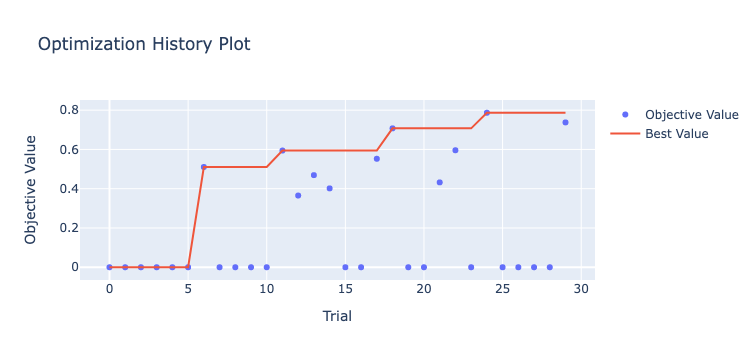

In [224]:
from optuna.visualization import plot_optimization_history
fig = plot_optimization_history(study)
#"./"+config.RESULTS_DIR+
#fig.write_image("./"+config.RESULTS_DIR+"/opt_hist.png")
fig.show()

In [225]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice


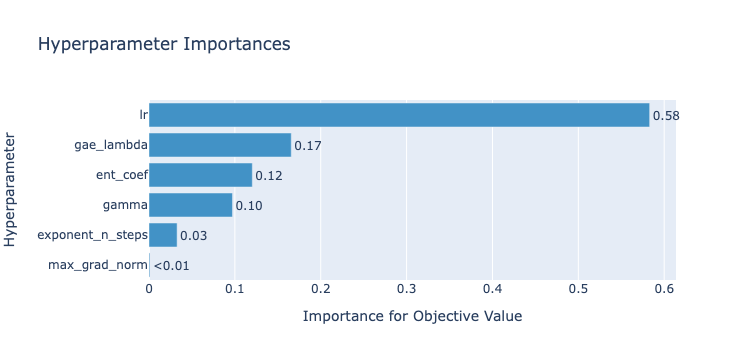

In [226]:
#Hyperparamters importance

try:
    fig = plot_param_importances(study)
#    fig.write_image("./"+config.RESULTS_DIR+"/params_importances.png")
    fig.show()
except:
    print('Cannot calculate hyperparameter importances: no variation')

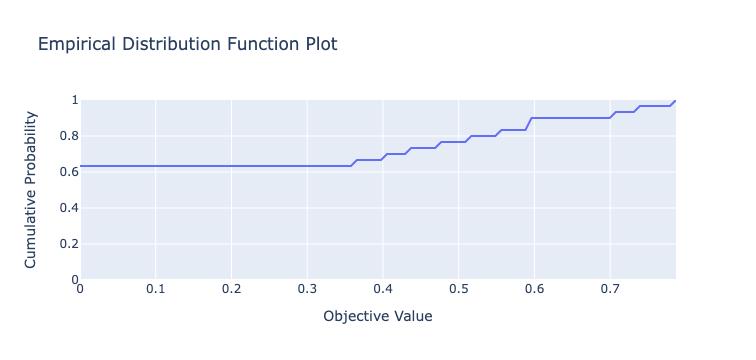

In [227]:
fig = plot_edf(study)
#fig.write_image("./"+config.RESULTS_DIR+"/emp_dist_func.png")
fig.show()